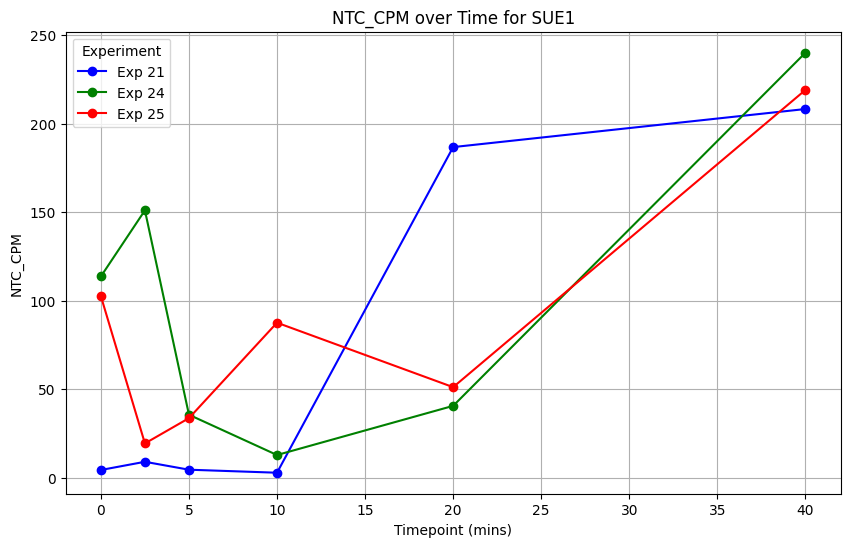

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('/Users/user/Documents/4TU_assay/IP combined analysis/ip combined analysis v5.csv')

# Filter the data for 'SUE1' with glucose=0 and exp=21, 24, or 25
filtered_data = data[(data['symbol'] == 'SUE1') & (data['glucose'] == 0) & (data['exp'].isin([21, 24, 25]))].copy()

# Check if the necessary columns are present in the filtered data
if not all(col in filtered_data.columns for col in ['timepoint', 'exp', 'NTC_CPM']):
    raise ValueError("Required columns are missing in the filtered data.")

# Define a color map for experiments
color_map = {21: 'blue', 24: 'green', 25: 'red'}

# Plot the NTC_CPM values over time for each experiment
fig, ax = plt.subplots(figsize=(10, 6))
for exp in filtered_data['exp'].unique():
    subset = filtered_data[filtered_data['exp'] == exp]
    subset = subset.sort_values('timepoint')  # Sort the subset by timepoint
    ax.plot(subset['timepoint'], subset['NTC_CPM'], marker='o', label=f'Exp {exp}', color=color_map[exp])
ax.set_xlabel('Timepoint (mins)')
ax.set_ylabel('NTC_CPM')
gene_name = 'SUE1'
ax.set_title(f'NTC_CPM over Time for {gene_name}')
ax.legend(title='Experiment')
plt.grid(True)
plt.show()

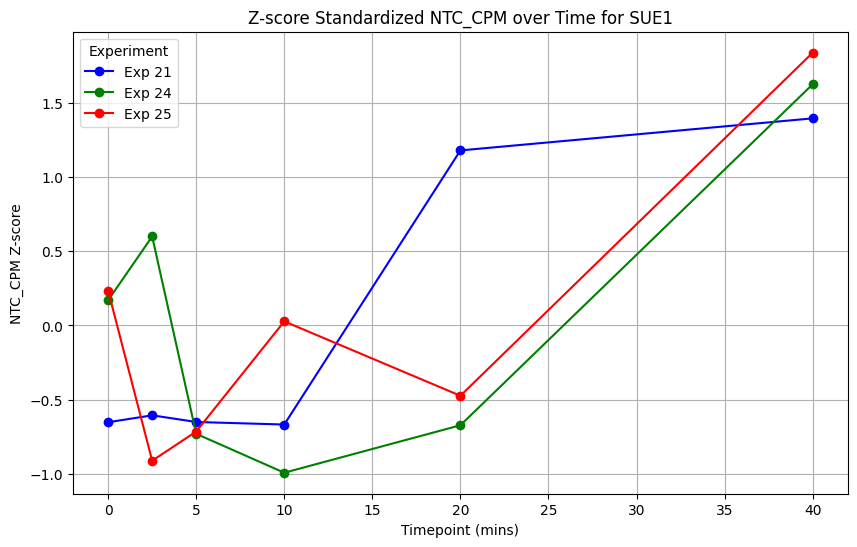

In [94]:
# Z-score standardization of the NTC_CPM values for each experiment
filtered_data.loc[:, 'NTC_CPM_zscore'] = filtered_data.groupby('exp')['NTC_CPM'].transform(lambda x: (x - x.mean()) / x.std())

# Plot the z-score standardized NTC_CPM values over time for each experiment
fig, ax = plt.subplots(figsize=(10, 6))
for exp in filtered_data['exp'].unique():
    subset = filtered_data[filtered_data['exp'] == exp]
    subset = subset.sort_values('timepoint')  # Sort the subset by timepoint
    ax.plot(subset['timepoint'], subset['NTC_CPM_zscore'], marker='o', label=f'Exp {exp}', color=color_map[exp])
ax.set_xlabel('Timepoint (mins)')
ax.set_ylabel('NTC_CPM Z-score')
ax.set_title(f'Z-score Standardized NTC_CPM over Time for {gene_name}')
ax.legend(title='Experiment')
plt.grid(True)
plt.show()

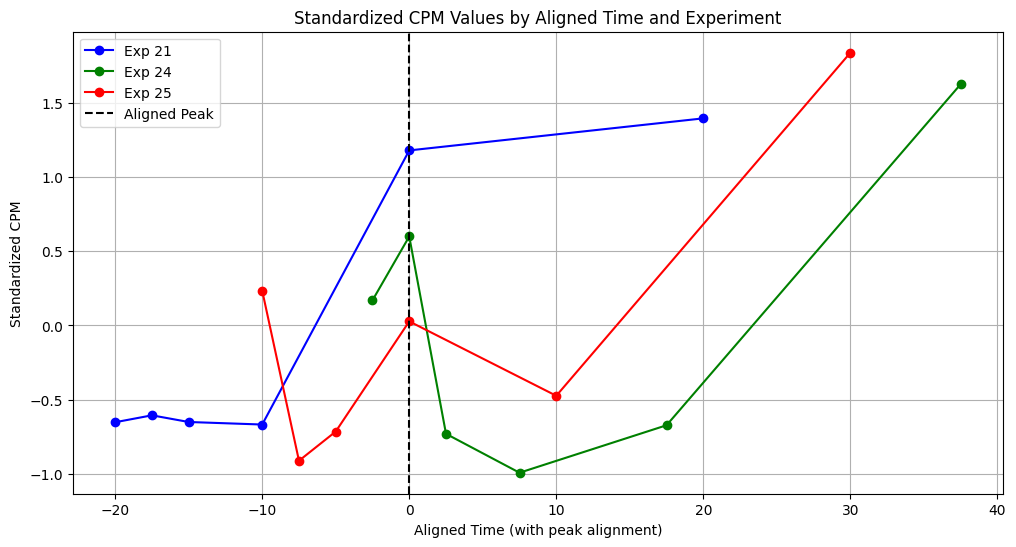

In [95]:
# Exclude the first (time 0) and last (time 40) data points for peak selection
peak_candidates = filtered_data[(filtered_data['timepoint'] != 0) & (filtered_data['timepoint'] != 40)]

# Identify the peak timepoint for each experiment based on standardized data
peak_times = peak_candidates.loc[peak_candidates.groupby('exp')['NTC_CPM_zscore'].idxmax(), ['timepoint', 'exp']].set_index('exp')

# Align peaks by shifting timepoints so that peaks occur at the same time for all experiments
filtered_data['aligned_time'] = filtered_data.apply(lambda x: x['timepoint'] - peak_times.loc[x['exp']], axis=1)

# Plot the standardized CPM values for each experiment after peak alignment
plt.figure(figsize=(12, 6))

for exp in filtered_data['exp'].unique():
    subset = filtered_data[filtered_data['exp'] == exp]
    subset = subset.sort_values('aligned_time')  # Sort the subset by aligned_time
    plt.plot(subset['aligned_time'], subset['NTC_CPM_zscore'], marker='o', label=f'Exp {exp}', linestyle='-', color=color_map[exp])

plt.title('Standardized CPM Values by Aligned Time and Experiment')
plt.xlabel('Aligned Time (with peak alignment)')
plt.ylabel('Standardized CPM')
plt.axvline(0, color='black', linestyle='--', label='Aligned Peak')
plt.legend()
plt.grid(True)
plt.show()

ANOVA Result: F=2.254494625056015, p-value=0.18611051366948506
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
     Peak Post-Peak   0.0261 0.9985 -1.5229 1.5752  False
     Peak  Pre-Peak  -0.9151  0.244 -2.4642  0.634  False
Post-Peak  Pre-Peak  -0.9412 0.2288 -2.4903 0.6079  False
---------------------------------------------------------


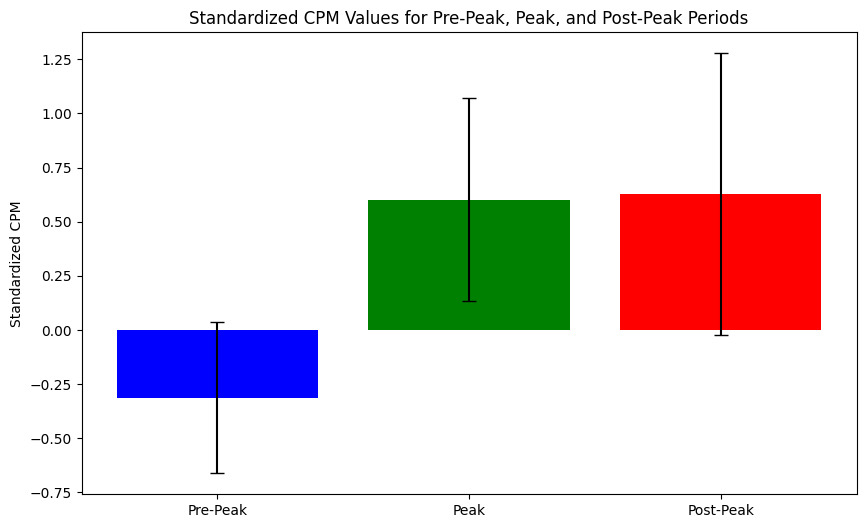

In [96]:
from scipy.stats import f_oneway
import statsmodels.stats.multicomp as mc
import numpy as np

# Function to calculate the period means for the statistical analysis
def calculate_period_means_aligned(df, exp):
    data_exp = df[df['exp'] == exp]
    pre_peak = data_exp[data_exp['aligned_time'] < 0]['NTC_CPM_zscore'].mean()
    peak = data_exp[data_exp['aligned_time'] == 0]['NTC_CPM_zscore'].mean()
    post_peak = data_exp[data_exp['aligned_time'] > 0]['NTC_CPM_zscore'].mean()
    return pre_peak, peak, post_peak

# Applying the function to each experiment
period_means_aligned = {exp: calculate_period_means_aligned(filtered_data, exp) for exp in filtered_data['exp'].unique()}

# Extracting values for ANOVA
pre_peak_values_aligned = [vals[0] for vals in period_means_aligned.values()]
peak_values_aligned = [vals[1] for vals in period_means_aligned.values()]
post_peak_values_aligned = [vals[2] for vals in period_means_aligned.values()]

# Combine all values into a single list with corresponding labels
combined_values = pre_peak_values_aligned + peak_values_aligned + post_peak_values_aligned
combined_labels = (['Pre-Peak'] * len(pre_peak_values_aligned) + 
                   ['Peak'] * len(peak_values_aligned) + 
                   ['Post-Peak'] * len(post_peak_values_aligned))

# Performing ANOVA across Pre-Peak, Peak, and Post-Peak periods
anova_result_aligned = f_oneway(pre_peak_values_aligned, peak_values_aligned, post_peak_values_aligned)
print(f"ANOVA Result: F={anova_result_aligned.statistic}, p-value={anova_result_aligned.pvalue}")

# Perform Post-Hoc Test (Tukey's HSD)
comp = mc.MultiComparison(combined_values, combined_labels)
post_hoc_result = comp.tukeyhsd()
print(post_hoc_result)

# Plotting the values of standardized CPM for pre-peak, peak, and post-peak periods
mean_values = [np.mean(pre_peak_values_aligned), np.mean(peak_values_aligned), np.mean(post_peak_values_aligned)]
std_values = [np.std(pre_peak_values_aligned), np.std(peak_values_aligned), np.std(post_peak_values_aligned)]
periods = ['Pre-Peak', 'Peak', 'Post-Peak']

plt.figure(figsize=(10, 6))
plt.bar(periods, mean_values, yerr=std_values, capsize=5, color=['blue', 'green', 'red'])
plt.ylabel('Standardized CPM')
plt.title('Standardized CPM Values for Pre-Peak, Peak, and Post-Peak Periods')
plt.show()